<a href="https://colab.research.google.com/github/SametSahin10/composer-classifier/blob/main/composer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pretty_midi
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Yolu verilen bir MIDI dosyasindan nota ve hiz bilgilerini okuyup donduruyoruz.
def extractNotesAndVelocities(path):
    # MIDI dosyasini okuyoruz.
    midi_data = pretty_midi.PrettyMIDI(path)

    # MIDI dosyasindaki nota ve hiz bilgilerini elde ediyoruz.
    notes = []
    velocities = []

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            notes.append(note.pitch)
            velocities.append(note.velocity)

    # Nota ve hiz bilgilerini NumPy array'lerine cevirip
    # fonksiyondan donduruyoruz.
    notes = np.array(notes)
    velocities = np.array(velocities)
    return notes, velocities

# Verilen kok dizinindeki tum klasorlerdeki MIDI dosyalarini okuyup
# bir dictionary'de sakliyoruz.
def createComposersDictionary(root_path):
    composers = {}

    for folder in os.listdir(root_path):
        for file in os.listdir(os.path.join(root_path, folder)):
            path = f'{root_path}/{folder}/{file}'

            # Iterasyon sirasinda bazi MIDI dosyalari okunurken olusabilecek
            # problemlere karsilik try-except kullandik.
            try:
                notes, velocities = extractNotesAndVelocities(path)
            except:
                print(f"Got an error while processing: {path}")
                continue

            data = [notes, velocities]
            dataAsNumpyArray = np.array(data)
            
            if folder in composers:
                composers[folder].append(dataAsNumpyArray)
            else:
                composers[folder] = [dataAsNumpyArray]

    return composers

composers = createComposersDictionary('/content/drive/MyDrive/collab/musicnet_midis')

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Got an error while processing: /content/drive/MyDrive/collab/musicnet_midis/Bach/2310_prelude15.mid
Got an error while processing: /content/drive/MyDrive/collab/musicnet_midis/Bach/2230_prelude20.mid


In [ ]:
# Sinir Agini olusturuyoruz.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2, 400)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation="softmax")
])

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
composer_name_to_index = {
    composer:index for index, composer in enumerate(os.listdir('/content/drive/MyDrive/collab/musicnet_midis'))
}

In [ ]:
composer_name_to_index

{'Mozart': 0,
 'Brahms': 1,
 'Dvorak': 2,
 'Haydn': 3,
 'Schubert': 4,
 'Bach': 5,
 'Beethoven': 6,
 'Faure': 7,
 'Ravel': 8,
 'Cambini': 9}

In [ ]:
# Sarkilarin uzunluklari farkli oldugundan
# her sarkiyi 400 notalik parcalara boluyoruz.
labels = []
features = []
for composer, notes_and_velocities in composers.items():
  for i in range(len(notes_and_velocities)):
    # Nota sayisindaki boyut farkliligini engellemek icin
    # nota sayisi 400'den az olan sarkilari hesaba katmiyoruz.
    if notes_and_velocities[i][0].shape[0] < 400: continue
    n = notes_and_velocities[i][0].shape[0] // 400
    increment = 0
    for index in range(n):
      notes = notes_and_velocities[i][0][increment:increment+400]
      velocities = notes_and_velocities[i][1][increment:increment+400]
      labels.append(composer_name_to_index[composer])

      data = [notes, velocities]
      dataAsNumpyArray = np.array(data)

      features.append(dataAsNumpyArray)
      increment+=400

In [ ]:
features = np.array(features)
labels = np.array(labels)

In [ ]:
# Elimizdeki verinin %20'sini test verisi olarak ayirdik.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [ ]:
# Modeli egitiyoruz.
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
65/65 [==============================] - 1s 8ms/step - loss: 13.0275 - accuracy: 0.3568 - val_loss: 2.5380 - val_accuracy: 0.4151
Epoch 2/10
65/65 [==============================] - 0s 4ms/step - loss: 2.5598 - accuracy: 0.4046 - val_loss: 2.1138 - val_accuracy: 0.4942
Epoch 3/10
65/65 [==============================] - 0s 4ms/step - loss: 1.8126 - accuracy: 0.4708 - val_loss: 1.6480 - val_accuracy: 0.5309
Epoch 4/10
65/65 [==============================] - 0s 4ms/step - loss: 1.6860 - accuracy: 0.5007 - val_loss: 1.7644 - val_accuracy: 0.4710
Epoch 5/10
65/65 [==============================] - 0s 6ms/step - loss: 1.6735 - accuracy: 0.5056 - val_loss: 1.5977 - val_accuracy: 0.5212
Epoch 6/10
65/65 [==============================] - 0s 4ms/step - loss: 1.6238 - accuracy: 0.5181 - val_loss: 1.7630 - val_accuracy: 0.4266
Epoch 7/10
65/65 [==============================] - 0s 3ms/step - loss: 1.6172 - accuracy: 0.5176 - val_loss: 1.6278 - val_accuracy: 0.5039
Epoch 8/10
65/65 [=

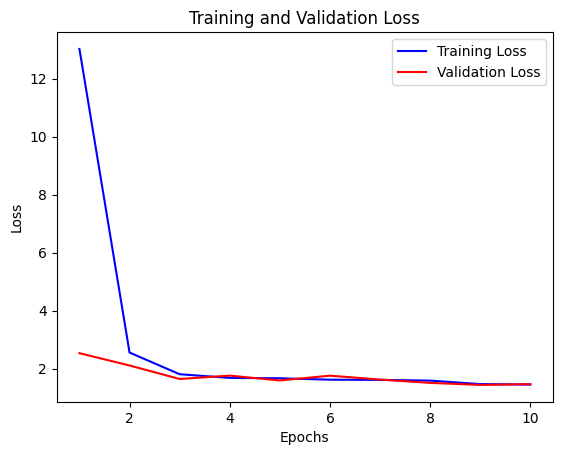

In [ ]:
# Training loss'u ve validation loss'u gorsellestirelim.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()